In [14]:
#Load packages
import os
import numpy as np 
import matplotlib.pyplot as plt

from src.battery_model import BatteryModel
from src.data_processing import process_data
from run import run_simulation

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Load data

battery_spec_file = os.path.join('data', 'battery_specs.csv')
half_hourly_price_file = os.path.join('data', 'half_hourly_data.csv')
daily_price_file = os.path.join('data', 'daily_data.csv')

battery_specs_dict, all_data = process_data(battery_spec_file, half_hourly_price_file, daily_price_file)

In [16]:
# test on small data
small_data = all_data.iloc[0:500]

In [17]:
output = run_simulation(battery_specs_dict, 
                        small_data.iloc[:144], 
                        planning_horizon=144,
                        execution_horizon=48,  
                        delta_t=0.5,
                        trading_freq=[1, 1, 48], 
                        S_init=0,
                        consider_depreciation=False)

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\zhout\Documents\Resume\Aurora_interview\battery_optimization\run.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output = pd.concat((output, plan), ignore_index=True)
100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


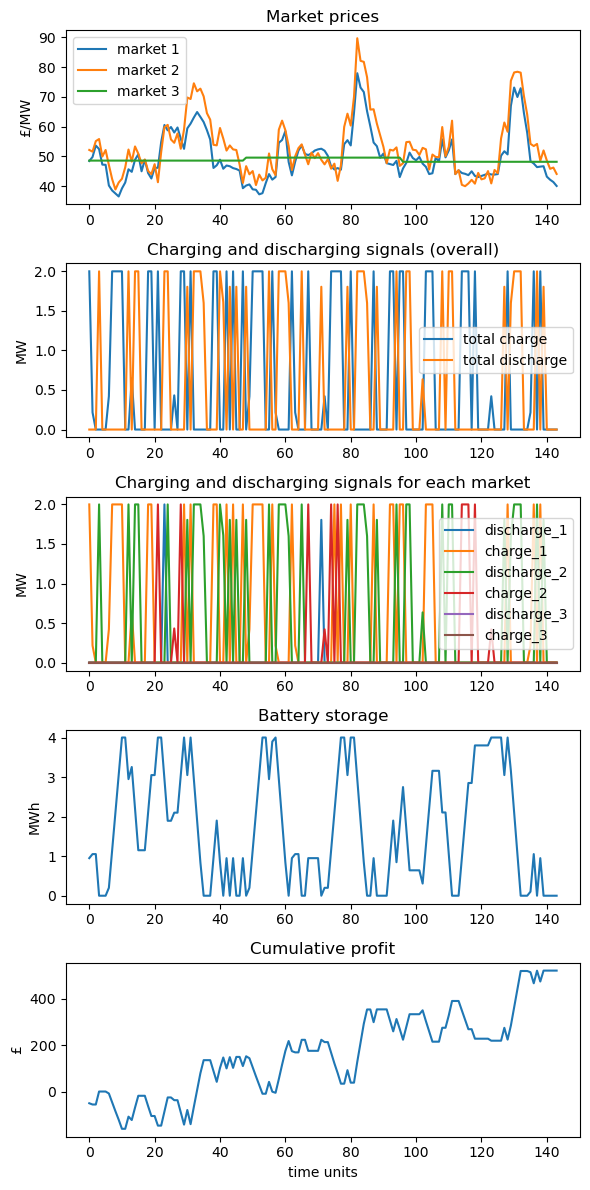

In [18]:
BatteryModel.plot_output(small_data.iloc[:144], output[:])

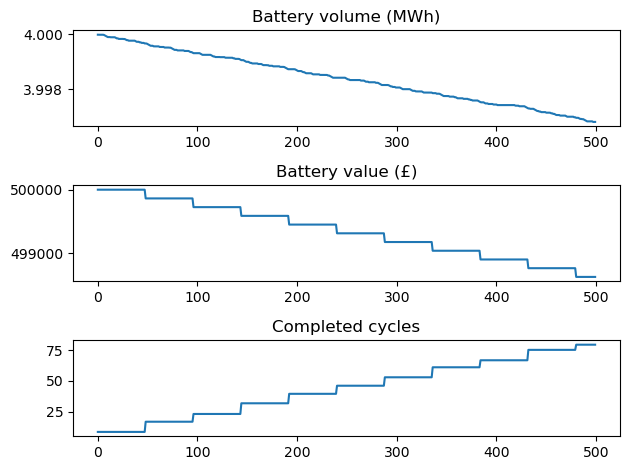

In [23]:
fig, axs = plt.subplots(3, 1)
axs[0].plot(output['Battery volume (MWh)'])
axs[1].plot(output['Battery value (£)'])
axs[2].plot(output['Completed cycles'])

axs[0].set_title('Battery volume (MWh)')
axs[1].set_title('Battery value (£)')
axs[2].set_title('Completed cycles')

plt.tight_layout()

## approximation of V_t

-9.900037123649063e-06


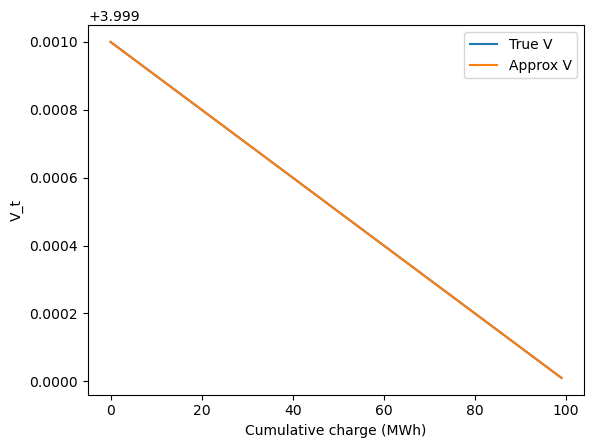

In [24]:
f = 1e-5
V_0 = 4
true_V = [V_0]
for i in range(1,100):
    cycle_per_charge = 1/true_V[-1]
    true_V.append(true_V[-1] * (1-f)**cycle_per_charge)
gradient = (true_V[-1] - true_V[0])/len(true_V)
print(gradient)

plt.plot(true_V, label='True V')
plt.plot([V_0 - f * c for c in range(100)], label='Approx V')
plt.ylabel('V_t')
plt.xlabel('Cumulative charge (MWh)')
plt.legend()

In [155]:
model = BatteryModel(small_data.iloc[:144].to_numpy(), horizon_length=144, trading_freq=[1, 1, 48], eta_C=0.95, eta_D=0.95)
model.create_model(consider_depreciation=True)
model.solve()
output = model.get_output()
print(model.get_profits())
#model.charge

371.92725270660003


In [156]:
from src.baseline_model import BaselineModel
%load_ext autoreload
%autoreload 2

baseline = BaselineModel(small_data.iloc[:144], horizon_length=144, trading_freq=[1, 1, 48], eta_C=0.95, eta_D=0.95)
output_baseline = baseline.get_output()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


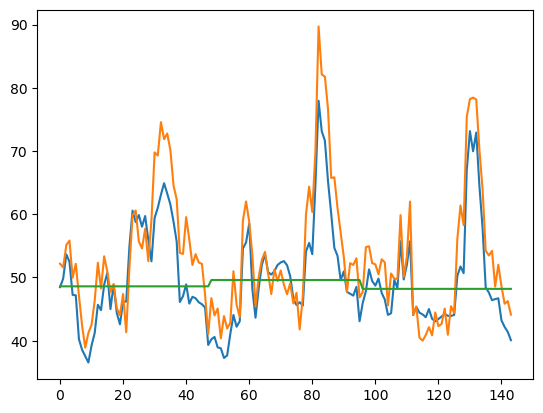

In [157]:
plt.plot(output_baseline['Market 1 Price [£/MWh]'])
plt.plot(output_baseline['Market 2 Price [£/MWh]'])
plt.plot(output_baseline['Market 3 Price [£/MWh]'])

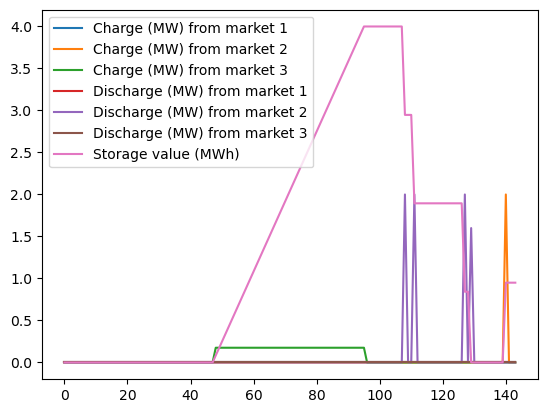

In [158]:
plt.plot(output_baseline['Charge (MW) from market 1'], label='Charge (MW) from market 1')
plt.plot(output_baseline['Charge (MW) from market 2'], label='Charge (MW) from market 2')
plt.plot(output_baseline['Charge (MW) from market 3'], label='Charge (MW) from market 3')

plt.plot(output_baseline['Discharge (MW) from market 1'], label='Discharge (MW) from market 1')
plt.plot(output_baseline['Discharge (MW) from market 2'], label='Discharge (MW) from market 2')
plt.plot(output_baseline['Discharge (MW) from market 3'], label='Discharge (MW) from market 3')

plt.plot(output_baseline['Storage value (MWh)'], label='Storage value (MWh)')

plt.legend()

In [160]:
profit = 0
for m in baseline.markets:
    profit += (output_baseline[f'Market {m} Price [£/MWh]'] * output_baseline[f'Charge (MW) from market {m}']).sum()
    profit -= (output_baseline[f'Market {m} Price [£/MWh]'] * output_baseline[f'Discharge (MW) from market {m}']).sum()
profit

27.752210526315366